In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(fastcluster)
library(here)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.1”

Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Warning message:
“package ‘ggplot2’ was built under R version 4.2.1”
Warning message:
“package ‘tibble’ was built under R version 4.2.1”
── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2.9000 ──
✔ forcats   1.0.0.9000     ✔ readr     2.1.4     
✔ ggplot

ERROR: Error in library(fastcluster): there is no package called ‘fastcluster’


In [2]:
working_location <- "/scratch/jpm73279/comparative_single_cell/09.ortholog_heatmap/00.data"

single_copy_ortho_group_files <- "Orthogroups_SingleCopyOrthologues.txt"
all_zm_vs_sb_orthologue_file <- "Zm_vs_Sb.all_orthologues.txt"

sb_meta_file <- "Sb_leaf_svd.knn_100_strict.meta.annotation_V1.txt"
sb_integration_event_file <- "sorghum_bicolor.gene_body_acc_leaf_svd_knn_100_strict.counts.tab.txt"
zm_integration_event_file <- "zea_mays.gene_body_acc_leaf_svd_knn_100_strict.counts.tab.txt"
zm_meta_file <- "Zm_leaf_svd.knn_100_strict.meta.annotation_V2.txt"

In [3]:

single_copy_ortho_group_list <- read_delim(here(working_location, single_copy_ortho_group_files), 
                                           col_names = c("ortho_groups"),
                                           delim = '\t')


zm_base <- "Zm"
sb_base <- "Sobic"
all_zm_vs_sb_orthologue <- read_delim(here(working_location, all_zm_vs_sb_orthologue_file), 
                                           col_names = FALSE,
                                           delim = ' ')  %>%
                            mutate(ortho_groups = str_replace(X1,":", ""))  %>% 
                            filter(ortho_groups %in% single_copy_ortho_group_list$ortho_groups)  %>% 
                            select(ortho_groups, X2, X3) %>%                            
                            rename("sb_gene" = X2)  %>% 
                            rename("zm_gene" = X3)  %>% 
                            mutate(zm_gene = str_replace(zm_gene, "_P00.*", "")) %>%
                            mutate(sb_gene = str_replace(sb_gene, "\\.[^\\.]*$", ""))
                            


Rows: 8909 Columns: 1
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): ortho_groups

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 47648 Columns: 350
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr (350): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
sb_meta_data <- read.delim(here(working_location, sb_meta_file))  %>% 
        separate(V1_annotation_n, c("annotation", "n_count"), sep = "_ncell_")

sb_raw_cpm_counts_all_genes <- read_delim(here(working_location,sb_integration_event_file), delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(sb_gene = gene_name)


sb_merged_meta_cpm_information <- left_join(sb_meta_data, sb_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(annotation, sb_gene)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

Rows: 35643126 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'annotation'. You can override using the `.groups` argument.


In [5]:
range01 <- function(x){(x-min(x))/(max(x)-min(x))}

In [6]:
### Read in Sb Data - Calculate CPM Values
sb_merged_meta_cpm_information_copied <- sb_merged_meta_cpm_information
sb_cpm_calculations <- sb_merged_meta_cpm_information_copied  %>%
    group_by(annotation) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()
sb_cpm_calculations_values <- as_tibble(sb_cpm_calculations)


sb_cpm_calculations_values <- ungroup(sb_cpm_calculations_values)
sb_merged_meta_cpm_information_copied<- bind_cols(sb_merged_meta_cpm_information_copied,sb_cpm_calculations_values)  %>% 
    rename(grouped_CPM = value)


sb_wider_plotting <- sb_merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = sb_gene, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -annotation, names_to = "sb_gene", values_to = "grouped_CPM") %>% 
    group_by(sb_gene) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    mutate(relative_accessability = range01(Zscore))  %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(annotation)  %>% 
    mutate(Zscore_group = scale(grouped_CPM)) %>% 
    filter(sb_gene %in% all_zm_vs_sb_orthologue$sb_gene)  %>% 
    left_join(., all_zm_vs_sb_orthologue, by = c("sb_gene")) 

In [7]:
head(sb_wider_plotting)

annotation,sb_gene,grouped_CPM,Zscore,relative_accessability,Zscore_group,ortho_groups,zm_gene
<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<chr>,<chr>
12,Sobic.001G000700,1.043944,-1.2892829,0.1355966,-0.60085865,OG0019753,Zm00001eb065360
12,Sobic.001G001400,22.966763,-0.8351773,0.0000000,-0.12168355,OG0020279,Zm00001eb065300
12,Sobic.001G003100,114.833815,1.1891243,0.8289385,1.88628833,OG0020508,Zm00001eb065160
12,Sobic.001G004400,30.274369,0.0946370,0.5492300,0.03804149,OG0020803,Zm00001eb210450
12,Sobic.001G004800,39.669863,-0.5065158,0.1326967,0.24340225,OG0020973,Zm00001eb065000
12,Sobic.001G005300,60.548739,0.3362430,0.4154967,0.69975949,OG0020703,Zm00001eb064970


In [8]:
## Read in Zm Data and calculate CPM 
zm_meta_data <- read.delim(here(working_location, zm_meta_file))  %>% 
        separate(V2_annotation_n, c("annotation", "n_count"), sep = "_ncell_")

zm_raw_cpm_counts_all_genes <- read_delim(here(working_location,zm_integration_event_file), delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(zm_gene = gene_name)


zm_merged_meta_cpm_information <- left_join(zm_meta_data, zm_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(annotation, zm_gene)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))


### Read in Zm Data - Calculate CPM Values
zm_merged_meta_cpm_information_copied <- zm_merged_meta_cpm_information
zm_cpm_calculations <- zm_merged_meta_cpm_information_copied  %>%
    group_by(annotation) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()
zm_cpm_calculations_values <- as_tibble(zm_cpm_calculations)


zm_cpm_calculations_values <- ungroup(zm_cpm_calculations_values)
zm_merged_meta_cpm_information_copied<- bind_cols(zm_merged_meta_cpm_information_copied,zm_cpm_calculations_values)  %>% 
    rename(grouped_CPM = value)


zm_wider_plotting <- zm_merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = zm_gene, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -annotation, names_to = "zm_gene", values_to = "grouped_CPM") %>% 
    group_by(zm_gene) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    mutate(relative_accessability = range01(Zscore))  %>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(annotation)  %>% 
    mutate(Zscore_group = scale(grouped_CPM)) %>% 
    filter(zm_gene %in% all_zm_vs_sb_orthologue$zm_gene)  %>% 
    left_join(., all_zm_vs_sb_orthologue, by = c("zm_gene")) 

Rows: 22169188 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'annotation'. You can override using the `.groups` argument.


In [9]:
head(sb_wider_plotting)

annotation,sb_gene,grouped_CPM,Zscore,relative_accessability,Zscore_group,ortho_groups,zm_gene
<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<chr>,<chr>
12,Sobic.001G000700,1.043944,-1.2892829,0.1355966,-0.60085865,OG0019753,Zm00001eb065360
12,Sobic.001G001400,22.966763,-0.8351773,0.0000000,-0.12168355,OG0020279,Zm00001eb065300
12,Sobic.001G003100,114.833815,1.1891243,0.8289385,1.88628833,OG0020508,Zm00001eb065160
12,Sobic.001G004400,30.274369,0.0946370,0.5492300,0.03804149,OG0020803,Zm00001eb210450
12,Sobic.001G004800,39.669863,-0.5065158,0.1326967,0.24340225,OG0020973,Zm00001eb065000
12,Sobic.001G005300,60.548739,0.3362430,0.4154967,0.69975949,OG0020703,Zm00001eb064970


In [10]:
present_orthos <- intersect(zm_wider_plotting$ortho_groups, sb_wider_plotting$ortho_groups)

zm_heatmap_pre_matrix_zscore <-  zm_wider_plotting  %>% 
    dplyr::select(annotation, ortho_groups, Zscore)  %>% 
    filter(ortho_groups %in% present_orthos)  %>% 
    pivot_wider(names_from = ortho_groups, values_from = Zscore)
    

sb_heatmap_pre_matrix_zscore <-  sb_wider_plotting  %>% 
    dplyr::select(annotation, ortho_groups, Zscore)  %>% 
    filter(ortho_groups %in% present_orthos)  %>%     
    pivot_wider(names_from = ortho_groups, values_from = Zscore)
    

same_grouping <- as.vector(intersect(sb_heatmap_pre_matrix_zscore[,1],zm_heatmap_pre_matrix_zscore[,1])  %>% 
                              filter(annotation != "xylem")) 
same_grouping

annotation
<chr>
bundle_sheath
epidermis
mesophyll
protoderm


In [11]:
sb_heatmap_pre_matrix.filtered <- t(as.matrix(sb_heatmap_pre_matrix_zscore %>%
    filter(annotation %in% same_grouping$annotation)))
    
zm_heatmap_pre_matrix.filtered <- t(as.matrix(zm_heatmap_pre_matrix_zscore  %>% 
    filter(annotation %in% same_grouping$annotation)))



colnames(sb_heatmap_pre_matrix.filtered) <- sb_heatmap_pre_matrix.filtered[1,]
sb_heatmap_pre_matrix.filtered <- sb_heatmap_pre_matrix.filtered[-1, ] 
class(sb_heatmap_pre_matrix.filtered) <- "numeric"

colname_order <- colnames(sb_heatmap_pre_matrix.filtered)

colnames(zm_heatmap_pre_matrix.filtered) <- zm_heatmap_pre_matrix.filtered[1,]
zm_heatmap_pre_matrix.filtered <- zm_heatmap_pre_matrix.filtered[-1, ] 
class(zm_heatmap_pre_matrix.filtered) <- "numeric"
zm_heatmap_pre_matrix.filtered <- zm_heatmap_pre_matrix.filtered[,colname_order]

In [12]:
head(sb_heatmap_pre_matrix.filtered)

,bundle_sheath,epidermis,mesophyll,protoderm
OG0019753,-0.61674657,-0.06296539,0.15128604,-1.26774808
OG0020279,-0.31475080,-0.81484740,-0.82555860,-0.44724870
OG0020508,0.98772020,-0.88304300,1.65060530,-0.88083620
OG0020803,-1.97095210,-0.54761340,-0.79105450,-0.80625010
OG0020973,-0.08791099,-1.03983798,0.09499027,-0.69603568
OG0020703,0.10600966,-0.81656300,2.78669204,0.05757234


In [13]:
zm.row <- t(apply(zm_heatmap_pre_matrix.filtered, 1, rank))
sb.row <- t(apply(sb_heatmap_pre_matrix.filtered, 1, rank))
ave <- (zm.row + sb.row)/2
row.o <- apply(ave, 1, which.max)
zm_heatmap_pre_matrix.filtered.order <- zm_heatmap_pre_matrix.filtered[ order(row.o, decreasing=F), ]
sb_heatmap_pre_matrix.filtered.order <- sb_heatmap_pre_matrix.filtered[ order(row.o, decreasing = F), ]

Warning message:
“Row names of heatmap 2 are not consistent with the main heatmap (1). It
may lead to wrong conclusion of your data. Please double check.”


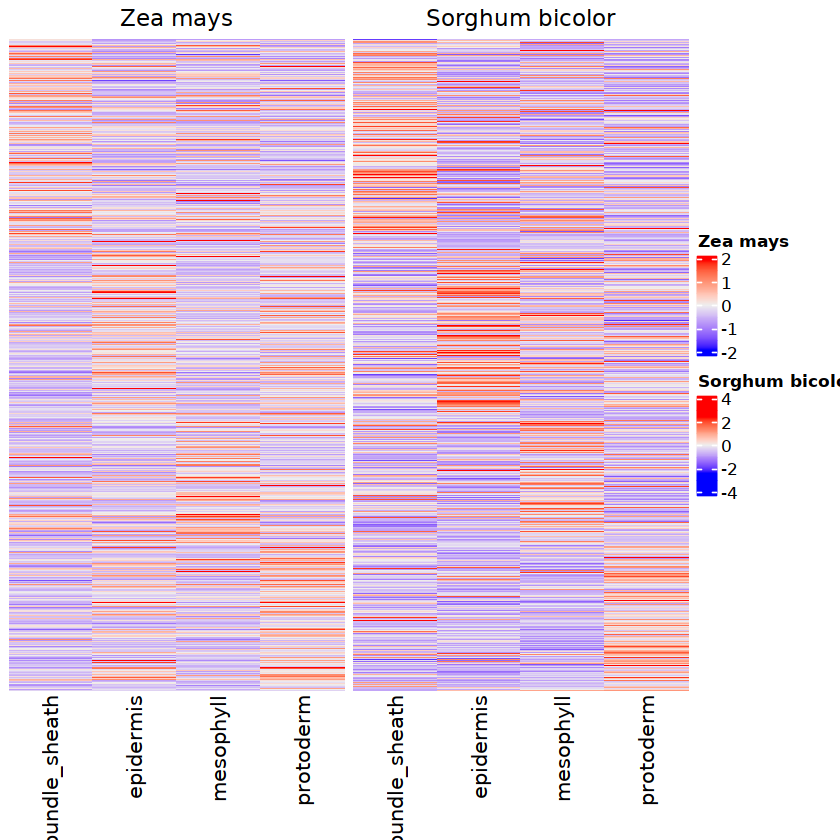

In [14]:
## INCORRECT ORDERING. BEWARE
zm_heatmap <- Heatmap(zm_heatmap_pre_matrix.filtered.order, name = "Zea mays", show_row_names = FALSE,
                      column_title = "Zea mays", cluster_rows = FALSE, cluster_columns = FALSE) 
sb_heatmap <- Heatmap(sb_heatmap_pre_matrix.filtered.order, name = "Sorghum bicolor", show_row_names = FALSE,
                      column_title = "Sorghum bicolor", cluster_rows = FALSE, cluster_columns = FALSE)

ht_list <- zm_heatmap + sb_heatmap 
draw(ht_list)

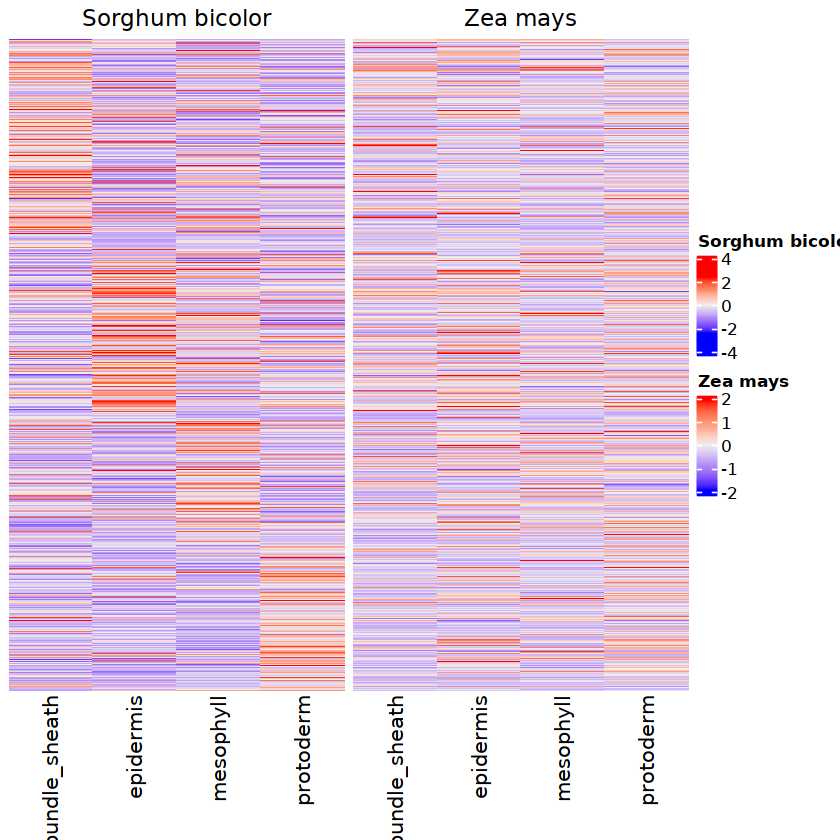

In [15]:
## Correct Ordering - Too Noisy

zm.row <- t(apply(zm_heatmap_pre_matrix.filtered, 1, rank))
sb.row <- t(apply(sb_heatmap_pre_matrix.filtered, 1, rank))
ave <- (zm.row + sb.row)/2
row.o <- apply(ave, 1, which.max)

sb_heatmap_pre_matrix.filtered.order <- sb_heatmap_pre_matrix.filtered[ order(row.o, decreasing=F), ]
zm_heatmap_pre_matrix.filtered.order <- zm_heatmap_pre_matrix.filtered[ (row.names(sb_heatmap_pre_matrix.filtered.order)), ]


zm_heatmap <- Heatmap(zm_heatmap_pre_matrix.filtered.order, name = "Zea mays", show_row_names = FALSE,
                      column_title = "Zea mays", cluster_rows = FALSE, cluster_columns = FALSE) 
sb_heatmap <- Heatmap(sb_heatmap_pre_matrix.filtered.order, name = "Sorghum bicolor", show_row_names = FALSE,
                      column_title = "Sorghum bicolor", cluster_rows = FALSE, cluster_columns = FALSE)

ht_list <- sb_heatmap + zm_heatmap
draw(ht_list)


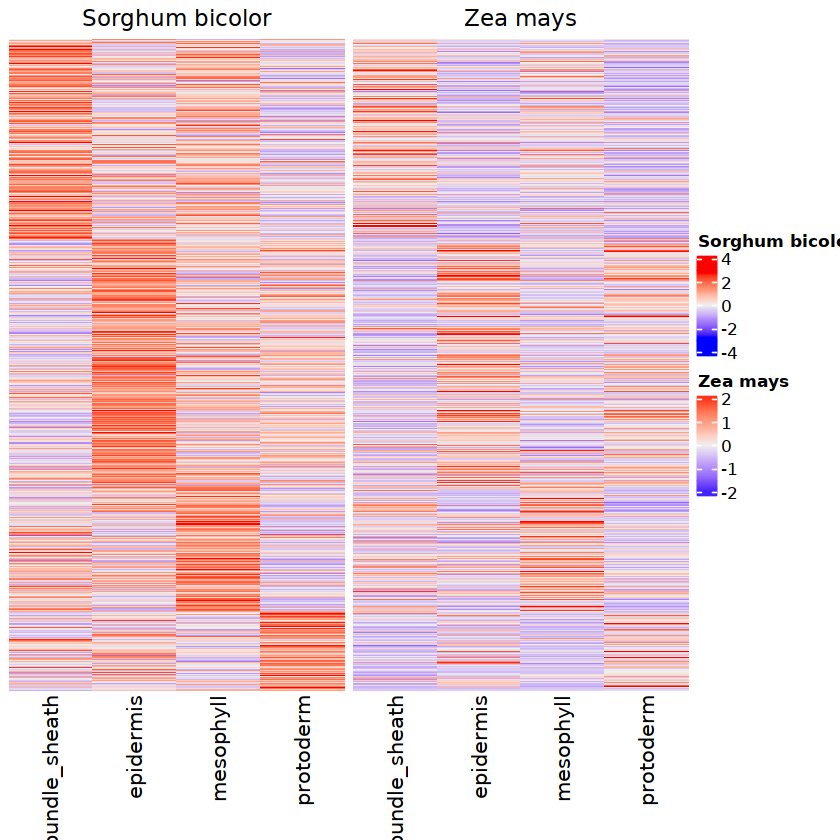

In [16]:
sb_filtered_posotive <- sb_heatmap_pre_matrix.filtered[rowSums(sb_heatmap_pre_matrix.filtered) > 1,]
zm_filtered_by_sb_posotive <- zm_heatmap_pre_matrix.filtered[rownames(sb_filtered_posotive),]


class(sb_filtered_posotive) <- "numeric"
class(zm_filtered_by_sb_posotive) <- "numeric"



zm.row <- t(apply(zm_filtered_by_sb_posotive, 1, rank))
sb.row <- t(apply(sb_filtered_posotive, 1, rank))
ave <- (zm.row + sb.row)/2
row.o <- apply(ave, 1, which.max)
zm_heatmap_pre_matrix.filtered.order <- zm_filtered_by_sb_posotive[ order(row.o, decreasing=F), ]
sb_heatmap_pre_matrix.filtered.order <- sb_filtered_posotive[ row.names(zm_heatmap_pre_matrix.filtered.order),  ]


zm_heatmap <- Heatmap(zm_heatmap_pre_matrix.filtered.order, name = "Zea mays", show_row_names = FALSE,
                      column_title = "Zea mays", cluster_rows = FALSE, cluster_columns = FALSE) 
sb_heatmap <- Heatmap(sb_heatmap_pre_matrix.filtered.order, name = "Sorghum bicolor", show_row_names = FALSE,
                      column_title = "Sorghum bicolor", cluster_rows = FALSE, cluster_columns = FALSE)

ht_list <- sb_heatmap + zm_heatmap
draw(ht_list)


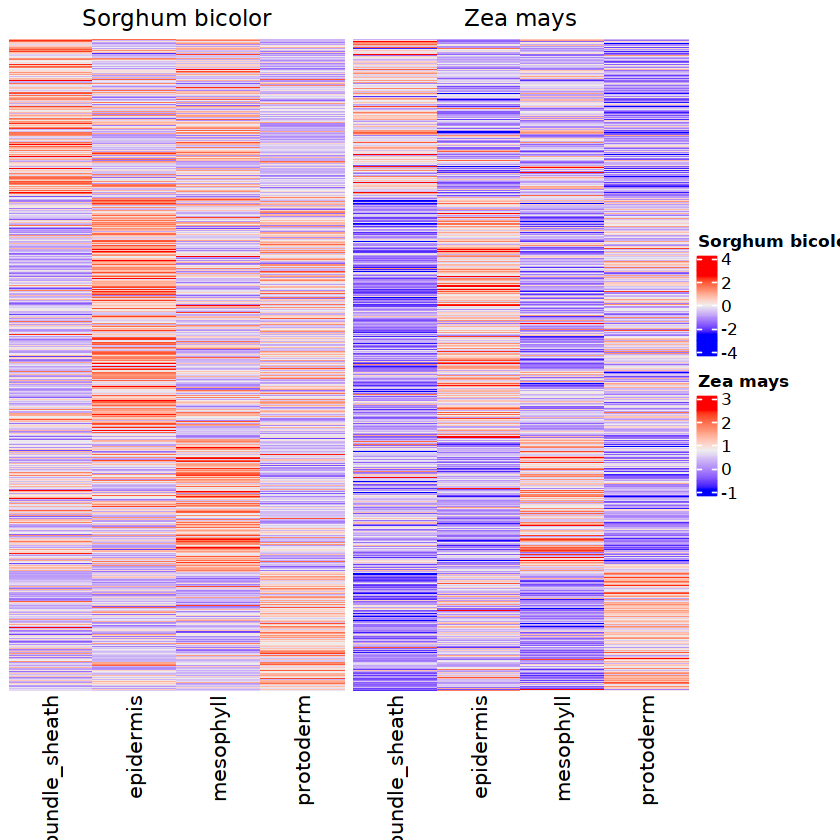

In [17]:
zm_filtered_by_sb_posotive <- zm_heatmap_pre_matrix.filtered[rowSums(zm_heatmap_pre_matrix.filtered) > 1,]
sb_filtered_posotive <- sb_heatmap_pre_matrix.filtered[row.names(zm_filtered_by_sb_posotive), ]


class(sb_filtered_posotive) <- "numeric"
class(zm_filtered_by_sb_posotive) <- "numeric"



zm.row <- t(apply(zm_filtered_by_sb_posotive, 1, rank))
sb.row <- t(apply(sb_filtered_posotive, 1, rank))
ave <- (zm.row + sb.row)/2
row.o <- apply(ave, 1, which.max)
zm_heatmap_pre_matrix.filtered.order <- zm_filtered_by_sb_posotive[ order(row.o, decreasing=F), ]
sb_heatmap_pre_matrix.filtered.order <- sb_filtered_posotive[ row.names(zm_heatmap_pre_matrix.filtered.order),  ]


zm_heatmap <- Heatmap(zm_heatmap_pre_matrix.filtered.order, name = "Zea mays", show_row_names = FALSE,
                      column_title = "Zea mays", cluster_rows = FALSE, cluster_columns = FALSE) 
sb_heatmap <- Heatmap(sb_heatmap_pre_matrix.filtered.order, name = "Sorghum bicolor", show_row_names = FALSE,
                      column_title = "Sorghum bicolor", cluster_rows = FALSE, cluster_columns = FALSE)

ht_list <- sb_heatmap + zm_heatmap
draw(ht_list)


In [18]:
sum(rowSums(zm_heatmap_pre_matrix.filtered) > 2 & rowSums(sb_heatmap_pre_matrix.filtered < -2))

[1] 3

Warning message in abs(rowSums(zm_heatmap_pre_matrix.filtered)) > 2 | abs(rowSums(sb_filtered_posotive)) > :
“longer object length is not a multiple of shorter object length”


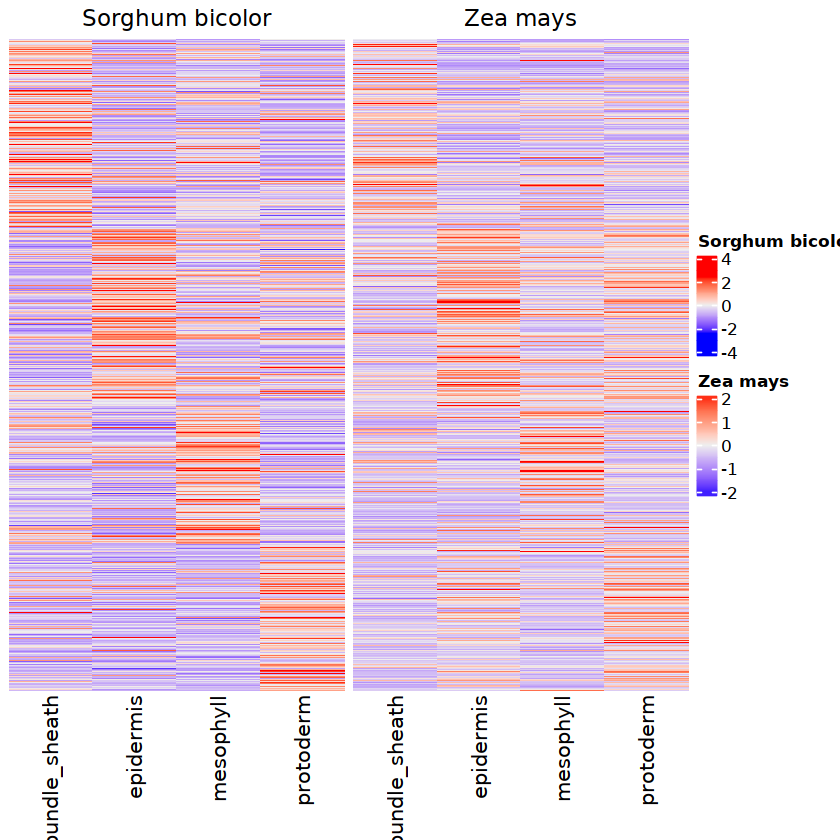

In [19]:
zm_filtered_by_sb_posotive <- zm_heatmap_pre_matrix.filtered[abs(rowSums(zm_heatmap_pre_matrix.filtered)) > 2 | abs(rowSums(sb_filtered_posotive)) > 2,]
sb_filtered_posotive <- sb_heatmap_pre_matrix.filtered[row.names(zm_filtered_by_sb_posotive), ]


class(sb_filtered_posotive) <- "numeric"
class(zm_filtered_by_sb_posotive) <- "numeric"



zm.row <- t(apply(zm_filtered_by_sb_posotive, 1, rank))
sb.row <- t(apply(sb_filtered_posotive, 1, rank))
ave <- (zm.row + sb.row)/2
row.o <- apply(ave, 1, which.max)
zm_heatmap_pre_matrix.filtered.order <- zm_filtered_by_sb_posotive[ order(row.o, decreasing=F), ]
sb_heatmap_pre_matrix.filtered.order <- sb_filtered_posotive[ row.names(zm_heatmap_pre_matrix.filtered.order),  ]


zm_heatmap <- Heatmap(zm_heatmap_pre_matrix.filtered.order, name = "Zea mays", show_row_names = FALSE,
                      column_title = "Zea mays", cluster_rows = FALSE, cluster_columns = FALSE) 
sb_heatmap <- Heatmap(sb_heatmap_pre_matrix.filtered.order, name = "Sorghum bicolor", show_row_names = FALSE,
                      column_title = "Sorghum bicolor", cluster_rows = FALSE, cluster_columns = FALSE)

ht_list <- sb_heatmap + zm_heatmap
draw(ht_list)


In [20]:
# Step 1: Call the pdf command to start the plot
pdf(file = "/home/jpm73279/EvoChromo_poster/ortholog_heatmap.annot_dotplot.pdf",
    width = 10, # The width of the plot in inches
    height = 15) # The height of the plot in inches

draw(ht_list)

dev.off()

png 
  2

In [ ]:

zm_heatmap <- Heatmap(zm_heatmap_pre_matrix.filtered.order, name = "Zea mays", show_row_names = FALSE,
                      column_title = "Zea mays", row_km = 6, row_km_repeats = 100,, cluster_columns = FALSE) 
sb_heatmap <- Heatmap(sb_heatmap_pre_matrix.filtered.order, name = "Sorghum bicolor", show_row_names = FALSE,
                      column_title = "Sorghum bicolor", cluster_rows = FALSE, cluster_columns = FALSE)

ht_list <- zm_heatmap + sb_heatmap
draw(ht_list)


In [34]:
zm_bed_genes <- "Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed"
sb_bed_genes <- "Sbicolorv5.1.gene.bed"


zm_genes <- read_delim(here(working_location, zm_bed_genes), 
                                           col_names = c("chrom", "start", "stop", "zm_gene"),
                                           delim = '\t')  %>% 
            select(chrom, start, stop, zm_gene)  %>% 
            mutate(zm_searchable_jbrowse_step_1 = str_c(chrom, start, sep = c(":")))  %>% 
            mutate(zm_searchable_jbrowse_step = str_c(zm_searchable_jbrowse_step_1, stop, sep = c("..")))  %>% 
            select(zm_gene, zm_searchable_jbrowse_step)

            


sb_genes <- read_delim(here(working_location, sb_bed_genes), 
                                           col_names = c("chrom", "start", "stop", "sb_gene"),
                                           delim = '\t')  %>% 
            select(chrom, start, stop, sb_gene)  %>% 
            mutate(sb_searchable_jbrowse_step_1 = str_c(chrom, start, sep = c(":")))  %>% 
            mutate(sb_searchable_jbrowse_step = str_c(sb_searchable_jbrowse_step_1, stop, sep = c("..")))  %>% 
            select(sb_gene, sb_searchable_jbrowse_step)

sb_meso_only <- sb_heatmap_pre_matrix.filtered.order[,("bundle_sheath")]
zm_meso_only <- zm_heatmap_pre_matrix.filtered.order[,("bundle_sheath")]

top_10_abs_difference_meso <- head(sort((sb_meso_only-zm_meso_only)),300)
top_10_abs_difference_all <- tail(sort(rowSums(abs(sb_heatmap_pre_matrix.filtered.order-zm_heatmap_pre_matrix.filtered.order))), 500)

all_zm_vs_sb_orthologue  %>% 
    left_join(., zm_genes, by = "zm_gene")  %>% 
    left_join(., sb_genes, by = "sb_gene")  %>% 
    filter(ortho_groups %in% names(top_10_abs_difference_meso)) 



Rows: 39756 Columns: 10
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): chrom, zm_gene, X5, X6, X7, X8, X9, X10
dbl (2): start, stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 35441 Columns: 10
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): chrom, sb_gene, X5, X6, X7, X8, X9, X10
dbl (2): start, stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ortho_groups,sb_gene,zm_gene,zm_searchable_jbrowse_step,sb_searchable_jbrowse_step
<chr>,<chr>,<chr>,<chr>,<chr>
OG0015932,Sobic.006G250500,Zm00001eb432720,chr10:148819927..148821356,Chr06:60347628..60349039
OG0015944,Sobic.006G275800,Zm00001eb076030,chr2:25694954..25698519,Chr06:62101899..62105621
OG0015945,Sobic.006G249100,Zm00001eb067630,chr2:4323026..4323329,Chr06:60250450..60251775
OG0015958,Sobic.006G279200,Zm00001eb434410,chr10:151505175..151514173,Chr06:62364220..62373630
OG0015964,Sobic.006G269600,Zm00001eb433880,chr10:150651747..150653852,Chr06:61627958..61630305
OG0015981,Sobic.006G274600,Zm00001eb065570,chr2:89392..107715,Chr06:61998678..62005193
OG0016009,Sobic.006G153900,Zm00001eb427000,chr10:134571864..134591745,Chr06:52793057..52803628
OG0016025,Sobic.006G281600,Zm00001eb434520,chr10:151944889..151946879,Chr06:62566528..62568922
OG0016059,Sobic.006G137300,Zm00001eb425930,chr10:130923197..130926612,Chr06:51357405..51360846


In [29]:
top_10_abs_difference_all

OG0021558 OG0020587 OG0025310 OG0021189 OG0019973 OG0023996 OG0016185 OG0016027 
0.1670050 0.1873954 0.1978262 0.2505105 0.2671818 0.2898572 0.2974537 0.3073212 
OG0022004 OG0016830 OG0019326 OG0020842 OG0020877 OG0023511 OG0023048 OG0025893 
0.3450929 0.3480033 0.3581982 0.3669269 0.3699414 0.3737730 0.3759279 0.3792751 
OG0020585 OG0022533 OG0015946 OG0023379 OG0020020 OG0016924 OG0021145 OG0021143 
0.3846023 0.3898526 0.3918649 0.3970980 0.3979996 0.4058682 0.4156684 0.4170884 
OG0023185 OG0023936 OG0026114 OG0019743 OG0020843 OG0019855 OG0017284 OG0021431 
0.4175188 0.4207200 0.4235802 0.4244774 0.4348620 0.4354816 0.4356931 0.4374999 
OG0020397 OG0021645 OG0018195 OG0018269 OG0019563 OG0017091 OG0020892 OG0025384 
0.4424369 0.4463725 0.4478232 0.4521744 0.4537070 0.4538692 0.4684019 0.4906035 
OG0021946 OG0016459 OG0021328 OG0019161 OG0016498 OG0017478 OG0019815 OG0021300 
0.4921500 0.4957275 0.5078480 0.5094329 0.5160509 0.5218879 0.5270375 0.5285887 
OG0017385 OG0025366 OG0024348 OG0022751 OG0017587 OG0020128 OG0024772 OG0018825 
0.5303244 0.5511809 0.5546032 0.5629093 0.5636576 0.5881709 0.5901249 0.5928153 
OG0018036 OG0016835 OG0022814 OG0021092 OG0016467 OG0022766 OG0017528 OG0020596 
0.5971381 0.5980143 0.6033818 0.6114719 0.6115695 0.6143003 0.6232039 0.6292990 
OG0018222 OG0021141 OG0018863 OG0024059 OG0016702 OG0022736 OG0023698 OG0015980 
0.6315855 0.6423598 0.6471160 0.6545105 0.6687988 0.6697024 0.6778702 0.6798559 
OG0017417 OG0023177 OG0016817 OG0016861 OG0022618 OG0022162 OG0020986 OG0016289 
0.6821260 0.6881012 0.6917231 0.6967696 0.6990204 0.7131687 0.7172402 0.7211097 
OG0016267 OG0017501 OG0015924 OG0023061 OG0023409 OG0018954 OG0017187 OG0020923 
0.7228141 0.7238412 0.7267598 0.7325041 0.7375691 0.7441820 0.7444693 0.7454591 
OG0016941 OG0019010 OG0023228 OG0024570 OG0019202 OG0024870 OG0019376 OG0021294 
0.7479156 0.7512943 0.7525335 0.7551740 0.7576238 0.7580276 0.7624771 0.7638134 
OG0017537 OG0019831 OG0017873 OG0021943 OG0023097 OG0020670 OG0025614 OG0018180 
0.7641564 0.7654529 0.7665283 0.7689947 0.7714578 0.7723871 0.7724000 0.7728500 
OG0018476 OG0026168 OG0023957 OG0018928 OG0020410 OG0023540 OG0024137 OG0018080 
0.7748273 0.7780374 0.7787255 0.7826770 0.7846108 0.7857568 0.7884857 0.7903037 
OG0019805 OG0019852 OG0016137 OG0016355 OG0015953 OG0025112 OG0025113 OG0018351 
0.7916273 0.7940297 0.7953294 0.8048106 0.8135644 0.8139511 0.8139511 0.8166392 
OG0022722 OG0025794 OG0024006 OG0019447 OG0021735 OG0024793 OG0018545 OG0020346 
0.8217205 0.8231344 0.8255710 0.8265397 0.8278454 0.8292264 0.8328327 0.8338476 
OG0018228 OG0019759 OG0024872 OG0016961 OG0021078 OG0017292 OG0026128 OG0025176 
0.8351668 0.8361832 0.8385539 0.8416678 0.8486293 0.8606955 0.8621423 0.8630324 
OG0023047 OG0020255 OG0025834 OG0020955 OG0019871 OG0017933 OG0022657 OG0016156 
0.8647187 0.8675585 0.8739674 0.8764704 0.8775044 0.8777598 0.8777857 0.8858822 
OG0018708 OG0019018 OG0021209 OG0026183 OG0026099 OG0021152 OG0024031 OG0022196 
0.8860384 0.8888438 0.8892371 0.8895465 0.8906412 0.8913594 0.8993667 0.9033290 
OG0023316 OG0024687 OG0025582 OG0022654 OG0024501 OG0026140 OG0020504 OG0022588 
0.9048381 0.9064327 0.9077988 0.9080597 0.9103157 0.9120521 0.9126856 0.9160575 
OG0023793 OG0019481 OG0024511 OG0016278 OG0016580 OG0024959 OG0024843 OG0019595 
0.9266048 0.9273728 0.9310547 0.9312360 0.9333527 0.9337395 0.9346457 0.9355297 
OG0021921 OG0021589 OG0024248 OG0017006 OG0025399 OG0016173 OG0019616 OG0021230 
0.9358990 0.9368105 0.9394811 0.9419462 0.9495077 0.9540566 0.9590639 0.9640812 
OG0021634 OG0021089 OG0020079 OG0024721 OG0024873 OG0024861 OG0024351 OG0016535 
0.9642126 0.9647884 0.9700207 0.9705453 0.9756041 0.9768815 0.9777596 0.9778025 
OG0016023 OG0024791 OG0016307 OG0025141 OG0021931 OG0018629 OG0020909 OG0024923 
0.9788141 0.9804498 0.9806707 0.9815810 0.9824255 0.9862847 0.9891445 0.9903845 
OG0021005 OG0019396 OG0016802 OG0017597 OG0018844 OG0023059 OG0022792 OG0020739 
0.9904814 0.9999667 1.0014264 1

In [26]:
tail(sort(rowSums(abs(sb_heatmap_pre_matrix.filtered.order-zm_heatmap_pre_matrix.filtered.order))), 10)

OG0024887 OG0020693 OG0017410 OG0020126 OG0024769 OG0018886 OG0020216 OG0021183 
 7.444847  7.473162  7.492482  7.502191  7.576741  7.735796  7.993559  8.379189 
OG0016398 OG0018415 
 8.662508  9.073555

In [ ]:
library(seriation)
o = seriate(max(zm_heatmap_pre_matrix.filtered.order) - zm_heatmap_pre_matrix.filtered.order, method = "BEA_TSP")

test_zm <- Heatmap(max(zm_heatmap_pre_matrix.filtered.order) - zm_heatmap_pre_matrix.filtered.order, name = "mat", 
    row_order = get_order(o, 1), cluster_columns = FALSE,
    column_title = "Zm")

o_sb = seriate(max(sb_heatmap_pre_matrix.filtered.order) - sb_heatmap_pre_matrix.filtered.order, method = "BEA")
test_sb <- Heatmap(max(sb_heatmap_pre_matrix.filtered.order) - sb_heatmap_pre_matrix.filtered.order, name = "mat", 
    row_order = get_order(o_sb, 1), cluster_columns = FALSE,
    column_title = "Sb")

draw(test_sb + test_zm)